In [2]:
import pandas as pd
import numpy as np

Import number of point of interest by areas in Shanghai

In [4]:
df_poi_per_district = pd.read_pickle("pickles/savedDF_POI_per_district.pickle")
df_poi_per_district.tail()

,NAME,TYPE,geometry,restaurant,Bicycle_park,Bus,Railway_station_entrance_exit,Convenience Store,Scenic_spot,Sport
261,???,2,POLYGON Z ((121.1862384675836 31.8099683739087...,15,123,0,0,2,4,1
262,????,2,POLYGON Z ((121.4058121348967 31.7971580391189...,0,1,0,0,0,0,0
263,???,2,POLYGON Z ((121.2444386611607 31.8444776771300...,17,57,0,0,5,1,5
264,????,2,POLYGON Z ((121.2677116383976 31.8487056227307...,0,1,0,0,0,0,0
265,???,2,POLYGON Z ((121.3905549664326 31.8229035233553...,0,21,0,0,3,0,2


*target* is what we try to predict. It's the result of a survey in Shanghai, were we quantified people's wellbeing with 3 criteria of their neighbourhood: smell, noise, and clean (which is a vague notion that also mean beautifulness). To predict these 3 values, we are going to create a weighted average, playing with the coef to have the more significant value.

In [5]:
target = pd.read_pickle("pickles/TARGET-communities-extract-wellbeing.pkl")

In [6]:
df_target = pd.DataFrame(data=target, columns=target[0])
df_target = df_target.drop(df_target.index[0])
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


# conversion

In [7]:
df_target = df_target[df_target['clean']!= '']
df_target = df_target[df_target['smell']!= '']
df_target = df_target[df_target['noise']!= '']
df_target = df_target[df_target['longitude']!= '']
df_target = df_target[df_target['latitude']!= '']


df_target['clean'] = df_target['clean'].apply(lambda x: float(x))
df_target['smell'] = df_target['smell'].apply(lambda x: float(x))
df_target['noise'] = df_target['noise'].apply(lambda x: float(x))
df_target['longitude'] = df_target['longitude'].apply(lambda x: float(x))
df_target['latitude'] = df_target['latitude'].apply(lambda x: float(x))

Smell and noise are binaries, 0 meaning no smell or noise. As a 4 in clean means very beautiful, we transformed every 0s in 1s, and vice versa.

In [8]:
df_target['smell'] = df_target['smell'].apply(lambda x: 1 if x==0  else 0)
df_target['noise'] = df_target['noise'].apply(lambda x: 1 if x==0  else 0)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3.0,1,1,盈浦街道,青浦区,121.104287,31.155882
2,万泰花园第一居委会,3.0,0,1,七宝镇,闵行区,121.351529,31.144327
3,万科阳光苑居委会,2.0,1,1,吴泾镇,闵行区,121.468520,31.042285
4,万豪居委会,3.0,1,1,长征镇,普陀区,121.367237,31.240725
6,万馨居委会,3.0,1,1,川沙新镇,浦东新区,121.668506,31.195306


# creation of the weighted average

In [9]:
clean_weight = 15
clean_noise = 1
clean_smell = 2

In [10]:
df_target['mean'] = (clean_weight*df_target['clean'] + clean_noise*df_target['noise'] + clean_smell*df_target['smell'])/(clean_weight+clean_noise+clean_smell)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,mean
1,万寿社区居委会,3.0,1,1,盈浦街道,青浦区,121.104287,31.155882,2.666667
2,万泰花园第一居委会,3.0,0,1,七宝镇,闵行区,121.351529,31.144327,2.555556
3,万科阳光苑居委会,2.0,1,1,吴泾镇,闵行区,121.468520,31.042285,1.833333
4,万豪居委会,3.0,1,1,长征镇,普陀区,121.367237,31.240725,2.666667
6,万馨居委会,3.0,1,1,川沙新镇,浦东新区,121.668506,31.195306,2.666667


# creation of geometrical points for each location

In [11]:
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd

In [12]:
df_ML = df_target[['mean','longitude','latitude']]

In [13]:
geometry = [Point(xy) for xy in zip(df_ML['longitude'], df_ML['latitude'])]

In [14]:
df_ML['geometry'] = geometry

/Users/rami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_ML.head()

,mean,longitude,latitude,geometry
1,2.666667,121.104287,31.155882,POINT (121.104287016932 31.1558823799679)
2,2.555556,121.351529,31.144327,POINT (121.351529089795 31.144326843509)
3,1.833333,121.468520,31.042285,POINT (121.468520387505 31.0422853979528)
4,2.666667,121.367237,31.240725,POINT (121.367237458941 31.2407251034807)
6,2.666667,121.668506,31.195306,POINT (121.668505522212 31.1953057158861)


In [16]:
gdf = gpd.GeoDataFrame(df_ML, geometry=df_ML.geometry)
gdf.plot()

cluster these values into the previous neighborhoods

In [17]:
happiness = {}
nb = 0
sum_mean = 0
for index, polygon in df_poi_per_district['geometry'].items():
    for mean, point in zip(df_ML['mean'], df_ML['geometry']):
        if point.within(polygon) == True:
            sum_mean += mean
            nb += 1
    if nb != 0 : 
        happiness[index] = sum_mean/nb
    else:
        happiness[index] = 0
    sum_mean = 0
    nb = 0

In [18]:
df_poi_per_district['happiness'] = happiness.values()
df_poi_per_district

,NAME,TYPE,geometry,restaurant,Bicycle_park,Bus,Railway_station_entrance_exit,Convenience Store,Scenic_spot,Sport,happiness
0,??,2,POLYGON Z ((121.4216787977396 30.6847124112995...,0,0,0,0,0,0,0,0.000000
1,???,2,POLYGON Z ((121.4119888989075 30.6937387337238...,0,0,0,0,0,0,0,0.000000
2,???,2,POLYGON Z ((121.4016307330431 30.7071734919907...,0,0,0,0,0,0,0,0.000000
3,????,2,POLYGON Z ((121.3368669670694 30.7380603821550...,748,197,0,0,134,28,229,0.000000
4,????,2,POLYGON Z ((121.2514316037695 30.7917653095429...,616,335,0,3,163,9,111,0.000000
5,???,2,POLYGON Z ((121.361791867899 30.80039372730244...,1131,333,0,5,128,14,167,2.666667
6,???,2,POLYGON Z ((121.1946455066587 30.8145337554495...,86,114,0,0,22,9,15,0.000000
7,???,2,POLYGON Z ((121.2968222983408 30.8189104622134...,177,190,0,8,55,12,37,2.250000
8,???,2,POLYGON Z ((121.3671342033205 30.8431074654533...,157,238,0,11,45,2,53,2.666667
9,???,2,POLYGON Z ((121.174529158719 30.87609875249207...,189,222,0,5,66,11,50,0.000000


In [19]:
X = df_poi_per_district[['restaurant', 'Bicycle_park', 'Bus', 'Railway_station_entrance_exit', 'Convenience Store', 'Scenic_spot', 'Sport']]
Y = df_poi_per_district['happiness']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}
reg = GradientBoostingRegressor()
search = GridSearchCV(reg, param_grid, cv=5)
search.fit(X_train,Y_train)

/Users/rami/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [22]:
search.best_params_

{'n_estimators': 100}

In [23]:
reg = GradientBoostingRegressor(n_estimators=100)
reg.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
Y_pred = reg.predict(X_test)

In [25]:
np.mean(np.abs(Y_pred - Y_test))

0.8658291125060351

(array([15.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,
         1.,  2.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,
         0.,  2.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

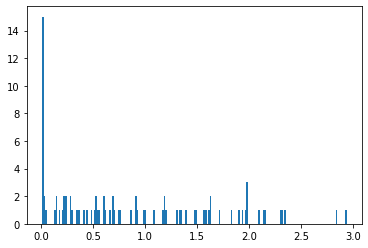

In [26]:
import matplotlib.pyplot as plt
plt.hist(np.abs(Y_pred - Y_test), 200)

In [27]:
Y_pred

array([ 1.89904995,  1.70837157,  2.27965721,  0.011483  ,  0.50285031,
        0.011483  ,  2.09875833,  2.32265325,  1.97946068,  2.04155662,
        0.96791839,  1.35329192,  0.29188134, -0.01287053,  0.011483  ,
        3.00476995,  0.54210902,  0.3531683 ,  2.1568588 ,  0.15801327,
        0.69727424,  0.90855389,  0.011483  ,  1.67545826,  1.57367515,
       -0.16912077,  1.21267452,  0.74164464,  0.011483  ,  1.55102657,
        1.96669958,  0.011483  ,  0.77786772,  1.09216914,  2.08498909,
        2.06890502,  2.09725676,  2.04814131,  2.84205697,  1.34090273,
        0.12739633,  1.58238678,  0.36692648,  0.40819229,  0.011483  ,
        1.49912385,  0.011483  , -0.04697135,  0.011483  ,  1.30355119,
        2.26339481,  0.011483  ,  0.65826916,  2.66385128,  2.41942306,
        0.5539206 ,  1.81459412,  1.02476425,  0.61932063,  1.29790839,
        1.96665895, -0.15413477,  0.011483  ,  2.34638218,  1.74824438,
        1.98482126,  1.55609098,  2.60628834,  1.47990697,  1.20

In [28]:
df_poi_per_district.head()

,NAME,TYPE,geometry,restaurant,Bicycle_park,Bus,Railway_station_entrance_exit,Convenience Store,Scenic_spot,Sport,happiness
0,??,2,POLYGON Z ((121.4216787977396 30.6847124112995...,0,0,0,0,0,0,0,0.0
1,???,2,POLYGON Z ((121.4119888989075 30.6937387337238...,0,0,0,0,0,0,0,0.0
2,???,2,POLYGON Z ((121.4016307330431 30.7071734919907...,0,0,0,0,0,0,0,0.0
3,????,2,POLYGON Z ((121.3368669670694 30.7380603821550...,748,197,0,0,134,28,229,0.0
4,????,2,POLYGON Z ((121.2514316037695 30.7917653095429...,616,335,0,3,163,9,111,0.0


In [ ]:
df_poi_per_district.to_csv(index=False)

In [32]:
df_poi_per_district['hapiness_proportion'] = df_poi_per_district['happiness']/df_poi_per_district['geometry'].area
df_poi_per_district.to_csv(index=False, path_or_buf='/Users/rami/OneDrive - Université de Technologie de Troyes/Cours/UTT/A2I_5/UM02/UM02-Deposit/Project/Map/shanghai_wellbeing.csv')